# 1. Setup

In [ ]:
# Standard library
from pathlib import Path
import tomllib

# Core libraries
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print

# Machine learning – preprocessing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Machine learning – evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer,
    recall_score
)

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load configuration
with open('config.toml', 'rb') as f:
   config = tomllib.load(f)

print("✅ Configuration loaded")

# Load dataset
dataset_path = Path('datasets/dataset_raw.csv')
df = pd.read_csv(dataset_path, delimiter=';')

print(f"✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]:,} columns")


✅ Configuration loaded

✅ Dataset loaded: 4,424 rows × 37 columns

In [3]:
# Create binary target (1=Withdrawal, 0=Continue)
df['target_binary'] = df['Target'].map({'Dropout': 1, 'Graduate': 0, 'Enrolled': 0})

In [4]:
print(f" - Final dataset: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

- Final dataset: 4,424 rows × 38 columns

# 2. Feature Selection

In [5]:
def normalise_column_names(df):
    """Normalise DataFrame column names to snake_case format"""
    def to_snake_case(name):
        # Convert to string, strip whitespace, lowercase
        name = str(name).strip().lower()
        # Replace spaces and apostrophes with underscores
        name = name.replace(' ', '_').replace("'", '')
        # Remove special characters
        name = name.replace('(', '').replace(')', '').replace('/', '_')
        name = name.replace('-', '_').replace('.', '_')
        # Clean up multiple underscores
        while '__' in name:
            name = name.replace('__', '_')
        # Remove trailing/leading underscores
        name = name.strip('_')
        return name
    
    df_copy = df.copy()
    original_cols = df_copy.columns.tolist()
    df_copy.columns = [to_snake_case(col) for col in df_copy.columns]
    
    # Validate no duplicate columns after normalization
    if len(set(df_copy.columns)) != len(df_copy.columns):
        duplicates = [col for col in df_copy.columns if df_copy.columns.tolist().count(col) > 1]
        raise ValueError(f"Column normalization created duplicates: {duplicates}")
    
    return df_copy

# Apply single comprehensive normalization
df = normalise_column_names(df)
print('✅ Column names normalised comprehensively (single pass)')

✅ Column names normalised comprehensively (single pass)

In [6]:
# Feature removal - drop problematic features
features_to_drop = [
    # Data leakage - 2nd semester features (remove to prevent future leakage)
    'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_without_evaluations', 'curricular_units_2nd_sem_grade',
    # Severely imbalanced features (>97% in one category)
    'nacionality', 'educational_special_needs', 'international',
    # Zero information value features
    'daytime_evening_attendance', 'displaced',
    # Weak predictors (correlation < 0.10)
    'unemployment_rate', 'inflation_rate', 'gdp', 'previous_qualification_grade',
    # Original target column
    'target'
]

# Check which features actually exist before dropping
existing_features = [col for col in features_to_drop if col in df.columns]
missing_features = [col for col in features_to_drop if col not in df.columns]

if missing_features:
    print(f'⚠️ Warning: Expected features not found: {missing_features}')
    
print(f'🗑️ Dropping {len(existing_features)} features: {existing_features}')
df = df.drop(columns=existing_features)

🗑️ Dropping 16 features: ['curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 
'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 
'curricular_units_2nd_sem_without_evaluations', 'curricular_units_2nd_sem_grade', 'nacionality', 
'educational_special_needs', 'international', 'daytime_evening_attendance', 'displaced', 'unemployment_rate', 
'inflation_rate', 'gdp', 'previous_qualification_grade', 'target']

# 3. Train Test Split

In [7]:
# Prepare features and target
X = df.drop('target_binary', axis=1)
y = df['target_binary']

# Split the data using config parameters
train_size = config['logistic_regression_model']['train_size']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=train_size,
    stratify=y,
    random_state=42
)

# Apply withdrawal rate encoding AFTER split to prevent data leakage
def encode_withdrawal_rate_safe(X_train, X_test, y_train, col):
    """Encode withdrawal rates using training data only"""
    # Ensure explicit index alignment to prevent data corruption
    X_train_aligned = X_train.reset_index(drop=True)
    y_train_aligned = y_train.reset_index(drop=True)
    
    temp_df = pd.concat([X_train_aligned[col], (y_train_aligned == 0)], axis=1)
    temp_df.columns = [col, 'is_withdrawal']
    rates = temp_df.groupby(col)['is_withdrawal'].mean()
    global_rate = (y_train_aligned == 0).mean()  # Fallback for unseen categories
    
    X_train[f'{col}_withdrawal_rate'] = X_train[col].map(rates)
    X_test[f'{col}_withdrawal_rate'] = X_test[col].map(rates).fillna(global_rate)
    X_train = X_train.drop(columns=[col])
    X_test = X_test.drop(columns=[col])
    return X_train, X_test

# Apply to medium cardinality features
for col in ['application_mode', 'course', 'previous_qualification']:
    X_train, X_test = encode_withdrawal_rate_safe(X_train, X_test, y_train, col)

# Create parental features AFTER split to prevent data leakage
higher_ed_codes = config['parental_features']['higher_education_codes']
professional_codes = config['parental_features']['professional_occupation_codes']

for X in [X_train, X_test]:
    # Create parental higher education binary indicator
    X['parental_higher_education'] = (
        (X['mothers_qualification'].isin(higher_ed_codes)) |
        (X['fathers_qualification'].isin(higher_ed_codes))
    ).astype(int)
    
    # Create parental professional occupation binary indicator
    X['parental_professional_occupation'] = (
        (X['mothers_occupation'].isin(professional_codes)) |
        (X['fathers_occupation'].isin(professional_codes))
    ).astype(int)
    
    # Drop original parental features
    X.drop(columns=['mothers_qualification', 'fathers_qualification', 
                   'mothers_occupation', 'fathers_occupation'], inplace=True)

# Calculate percentages and display results
train_pct = int(train_size * 100)
test_pct = 100 - train_pct

print(f'📊 Data split ({train_pct}/{test_pct}):')
print(f'   Training: {X_train.shape[0]:,} samples')
print(f'   Test: {X_test.shape[0]:,} samples')

print(f'\n🎯 Class distribution:')
print(f'   Training: {y_train.value_counts().to_dict()}')
print(f'   Test: {y_test.value_counts().to_dict()}')

# Verify class balance is maintained
train_ratio = y_train.mean()
test_ratio = y_test.mean()
print(f'\n✅ Continuation rate: Train={train_ratio:.3f}, Test={test_ratio:.3f}')
print(f'✅ All feature encoding applied safely (training data only)')

📊 Data split (80/20):

Training: 3,539 samples

Test: 885 samples

🎯 Class distribution:

Training: {0: 2402, 1: 1137}

Test: {0: 601, 1: 284}

✅ Continuation rate: Train=0.321, Test=0.321

✅ All feature encoding applied safely (training data only)

# 4. Pipeline

In [8]:
# Get scaler type from config
scaler_type = config['logistic_regression_model']['scaler_type']

if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError(f'Unknown scaler type: {scaler_type}')

# Get feature lists from config and filter for features that actually exist in our processed dataset
config_continuous = config['dataset_features']['continuous_features']
config_categorical = config['dataset_features']['categorical_features']

# Filter continuous features to only include those present after all transformations
continuous_features = [f for f in config_continuous if f in X_train.columns]

# Add withdrawal rate features if they were created successfully during preprocessing
expected_withdrawal_features = ['application_mode_withdrawal_rate', 'course_withdrawal_rate', 
                               'previous_qualification_withdrawal_rate']
existing_withdrawal_features = [f for f in expected_withdrawal_features if f in X_train.columns]
missing_withdrawal_features = [f for f in expected_withdrawal_features if f not in X_train.columns]

if missing_withdrawal_features:
    print(f'⚠️ Warning: Expected withdrawal rate features missing: {missing_withdrawal_features}')
    
print(f'✅ Found {len(existing_withdrawal_features)} withdrawal rate features: {existing_withdrawal_features}')
continuous_features.extend(existing_withdrawal_features)

# Filter categorical features to only include those present after transformations
categorical_features = [f for f in config_categorical if f in X_train.columns]

# Binary features created during preprocessing
binary_features = ['parental_higher_education', 'parental_professional_occupation']

# Verify all features are explicitly handled
all_handled_features = continuous_features + categorical_features + binary_features
actual_features = X_train.columns.tolist()
unhandled_features = set(actual_features) - set(all_handled_features)

if unhandled_features:
    print(f'⚠️ Unhandled features detected: {sorted(unhandled_features)}')
    print('🔧 Please categorise these features explicitly')
    raise ValueError(f'All features must be explicitly categorised. Unhandled: {unhandled_features}')

# Create preprocessing pipeline with explicit feature handling only
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, continuous_features),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('passthrough', 'passthrough', binary_features)
    ],
    remainder='drop'
)

print(f'🔧 Preprocessing pipeline created:')
print(f'   Scaler: {scaler_type} (applied to {len(continuous_features)} continuous features)')
print(f'   One-hot encoder: {len(categorical_features)} categorical features')
print(f'   Binary features (no scaling): {len(binary_features)} features')
print(f'✅ All {len(all_handled_features)} features explicitly handled')

✅ Found 3 withdrawal rate features: ['application_mode_withdrawal_rate', 'course_withdrawal_rate', 
'previous_qualification_withdrawal_rate']

🔧 Preprocessing pipeline created:

Scaler: standard (applied to 11 continuous features)

One-hot encoder: 6 categorical features

Binary features (no scaling): 2 features

✅ All 19 features explicitly handled

# 5. Model Training

In [9]:
# Create withdrawal recall scorer (withdrawal detection rate)
withdrawal_recall_scorer = make_scorer(recall_score, pos_label=1)

In [10]:

# Get parameters from config
logistic_config = config['logistic_regression_model']
grid_config = config['logistic_regression_grid_search']
cv_folds = config['logistic_regression_grid_search']['cv_folds']

# Convert config values
class_weights = [None if w == "none" else w for w in grid_config['class_weights']]

# Define parameter grid using config values
param_grid = [
    {
        'classifier__C': grid_config['C_values'],
        'classifier__penalty': ['l1'],
        'classifier__solver': ['liblinear'], 
        'classifier__class_weight': class_weights
    },
    {
        'classifier__C': grid_config['C_values'],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs'],
        'classifier__class_weight': class_weights
    }
]

# Create pipeline using config values
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=grid_config['random_state'], 
        max_iter=grid_config['max_iter']
    ))
])

# Calculate total combinations
total_combinations = sum(len(grid['classifier__C']) * len(grid['classifier__class_weight']) for grid in param_grid)

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
    scoring=withdrawal_recall_scorer,
    n_jobs=-1,
    verbose=1
)

print(f'🔍 Starting grid search with {total_combinations} combinations')
print(f'   CV folds: {cv_folds} (from config)')

# Fit the model
grid_search.fit(X_train, y_train)

print(f'\n✅ Best parameters: {grid_search.best_params_}')
print(f'✅ Best CV score (withdrawal recall): {grid_search.best_score_:.3f}')

🔍 Starting grid search with 20 combinations

CV folds: 5 (from config)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


✅ Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 
'classifier__solver': 'lbfgs'}

✅ Best CV score (withdrawal recall): 0.783

In [11]:
# Quick check to see which categorical feature has unseen categories
for i, cat_feature in enumerate(categorical_features):
    train_cats = set(X_train[cat_feature].unique())
    test_cats = set(X_test[cat_feature].unique())
    unseen = test_cats - train_cats
    if unseen:
        print(f'{cat_feature} has unseen categories in test: {unseen}')

# 6. Evaluation

📊 Model Performance:

Accuracy: 0.846

Withdrawal recall (class-1): 0.782

Continuation recall (class-0): 0.877

Precision (withdrawal): 0.750

🔍 CV Scorer Alignment:

Grid search optimised: Class-1 recall = 0.782

Best CV score was: 0.783

🎯 Confusion Matrix:

True Negatives (correct continuations): 527

False Positives (incorrectly predicted withdrawals): 74

False Negatives (missed withdrawals): 62

True Positives (correct withdrawals): 222

📈 Classification Report:

precision    recall  f1-score   support

Continuation       0.89      0.88      0.89       601
  Withdrawal       0.75      0.78      0.77       284

    accuracy                           0.85       885
   macro avg       0.82      0.83      0.83       885
weighted avg       0.85      0.85      0.85       885

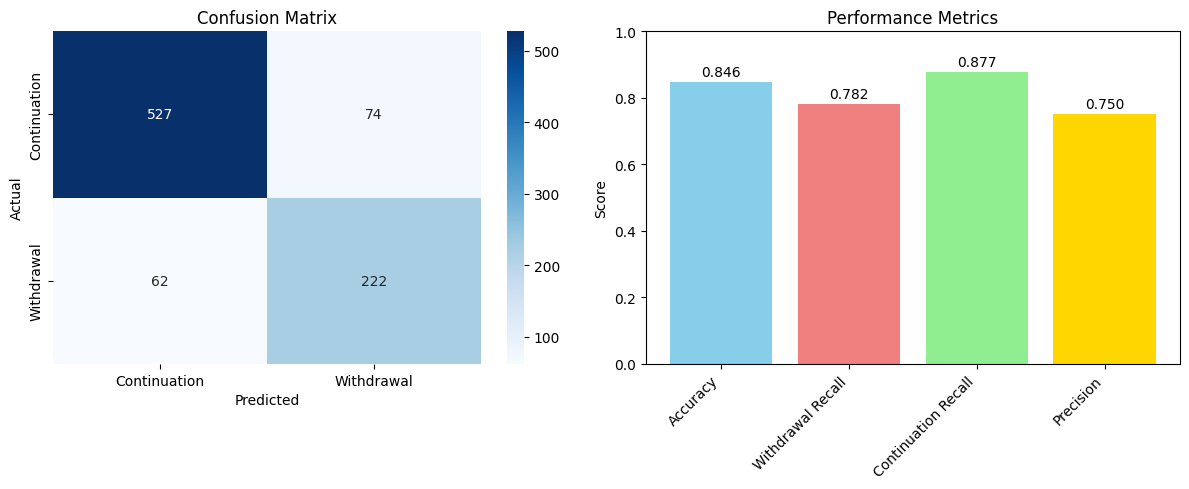

✅ Logistic Regression Model Complete!

Best configuration: C=0.1, penalty=l2

In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Validate confusion matrix shape
if cm.shape != (2, 2):
    raise ValueError(f'Expected 2x2 confusion matrix, got {cm.shape}. Check that both classes are present in predictions.')

# Calculate specific metrics for withdrawal prediction
tn, fp, fn, tp = cm.ravel()
withdrawal_recall = tp / (tp + fn)  # Class-1 recall (withdrawals)
continuation_recall = tn / (tn + fp)  # Class-0 recall (continuations)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision for withdrawals

print('📊 Model Performance:')
print(f'   Accuracy: {accuracy:.3f}')
print(f'   Withdrawal recall (class-1): {withdrawal_recall:.3f}')
print(f'   Continuation recall (class-0): {continuation_recall:.3f}')
print(f'   Precision (withdrawal): {precision:.3f}')

# Add explicit note about CV scorer alignment
print(f'\n🔍 CV Scorer Alignment:')
print(f'   Grid search optimised: Class-1 recall = {withdrawal_recall:.3f}')
print(f'   Best CV score was: {grid_search.best_score_:.3f}')

print(f'\n🎯 Confusion Matrix:')
print(f'   True Negatives (correct continuations): {tn}')
print(f'   False Positives (incorrectly predicted withdrawals): {fp}')
print(f'   False Negatives (missed withdrawals): {fn}')
print(f'   True Positives (correct withdrawals): {tp}')

# Detailed classification report
print(f'\n📈 Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Continuation', 'Withdrawal']))

# Create visualisation of results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Continuation', 'Withdrawal'],
           yticklabels=['Continuation', 'Withdrawal'],
           ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Performance Metrics Bar Chart
metrics = ['Accuracy', 'Withdrawal Recall', 'Continuation Recall', 'Precision']
values = [accuracy, withdrawal_recall, continuation_recall, precision]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = axes[1].bar(metrics, values, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Performance Metrics')
axes[1].set_ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f'✅ Logistic Regression Model Complete!')
print(f'Best configuration: C={grid_search.best_params_["classifier__C"]}, '
      f'penalty={grid_search.best_params_["classifier__penalty"]}')

Creating Threshold vs Performance Chart

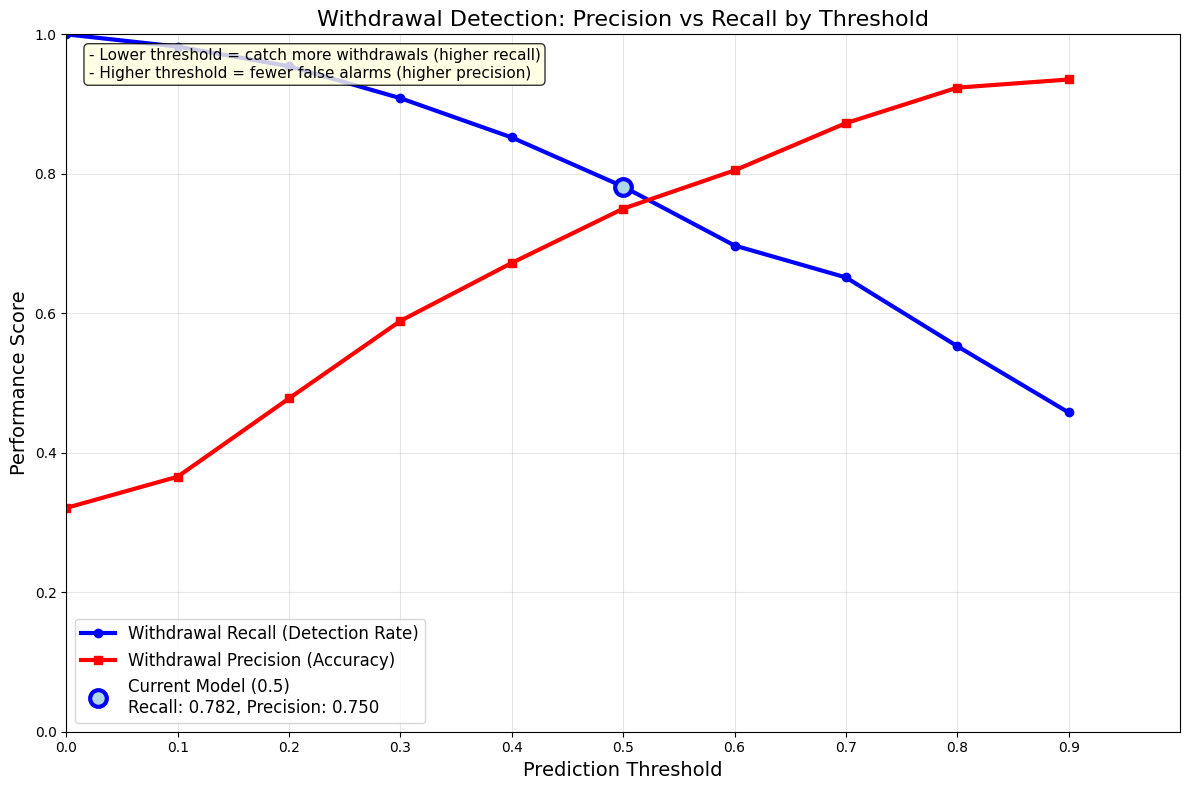

Threshold Performance Analysis:

,Threshold,Withdrawal_Recall,Withdrawal_Precision,Current_Model
0,0.0,1.000,0.321,
1,0.1,0.982,0.366,
2,0.2,0.954,0.478,
3,0.3,0.908,0.589,
4,0.4,0.852,0.672,
5,0.5,0.782,0.750,← CURRENT
6,0.6,0.697,0.805,
7,0.7,0.651,0.873,
8,0.8,0.553,0.924,
9,0.9,0.458,0.935,


In [21]:
# Threshold vs Performance Chart
print("Creating Threshold vs Performance Chart")

# Define threshold range (0.0 to 1.0 in 0.1 increments)
thresholds = np.arange(0.0, 1.0, 0.1)

# Store results
withdrawal_precisions = []
withdrawal_recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Make predictions using this threshold
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    
    # Handle edge cases where no predictions are made for a class
    if cm_thresh.shape != (2, 2):
        # If threshold is too high/low, some classes might not be predicted
        if threshold >= 1.0:
            # No withdrawals predicted
            withdrawal_recalls.append(0.0)
            withdrawal_precisions.append(0.0)
        else:
            # All predicted as withdrawals
            withdrawal_recalls.append(1.0)
            withdrawal_precisions.append(sum(y_test) / len(y_test))
    else:
        tn, fp, fn, tp = cm_thresh.ravel()
        
        # Withdrawal recall (sensitivity for class 1)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        # Withdrawal precision (positive predictive value for class 1)  
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        
        withdrawal_recalls.append(recall)
        withdrawal_precisions.append(precision)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot both lines
plt.plot(thresholds, withdrawal_recalls, 'b-', linewidth=3, marker='o', markersize=6, 
         label='Withdrawal Recall (Detection Rate)')
plt.plot(thresholds, withdrawal_precisions, 'r-', linewidth=3, marker='s', markersize=6, 
         label='Withdrawal Precision (Accuracy)')

# Mark current model (0.5 threshold)
current_idx = 5  # 0.5 is at index 5 in our array
plt.plot(0.5, withdrawal_recalls[current_idx], 'bo', markersize=12, 
         markerfacecolor='lightblue', markeredgecolor='blue', markeredgewidth=3,
         label=f'Current Model (0.5)\nRecall: {withdrawal_recalls[current_idx]:.3f}, Precision: {withdrawal_precisions[current_idx]:.3f}')

# Formatting
plt.xlabel('Prediction Threshold', fontsize=14)
plt.ylabel('Performance Score', fontsize=14)
plt.title('Withdrawal Detection: Precision vs Recall by Threshold', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add threshold labels on x-axis
plt.xticks(thresholds, [f'{t:.1f}' for t in thresholds])

# Add text box with guidance
textstr = '''- Lower threshold = catch more withdrawals (higher recall)\n- Higher threshold = fewer false alarms (higher precision)'''

plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# Create clean results dataframe
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Withdrawal_Recall': withdrawal_recalls,
    'Withdrawal_Precision': withdrawal_precisions
})

# Round to 3 decimal places for cleaner display
results_df = results_df.round(3)

# Add a marker for current model
results_df['Current_Model'] = results_df['Threshold'].apply(lambda x: '← CURRENT' if x == 0.5 else '')

print("Threshold Performance Analysis:")
display(results_df)